<h1 style="text-align: center;">Modeling Shot Success of NBA players on a FIBA court: A Scientific and Data-Driven Approach</h1>

<p style="text-align: justify;">
Basketball is one of the most popular sports in the world, known for its fast pace, dynamic strategy, and high-scoring games. Central to the game is the concept of shooting: a player attempts to score by throwing the basketball through the opponent’s hoop. Depending on the distance and type of shot, it can count for either two or three points. A made shot from beyond the three-point arc earns three points, while shots from inside this arc count for two. Free throws, awarded in specific situations, are worth one point each.
</p>

<p style="text-align: justify;">
Given how vital scoring is to a team’s success, understanding the probability of a successful shot from different court positions can provide valuable strategic insights. This project explores that very question: <b>How probable is an NBA player to score from different positions on the court?</b> 
Using real-world data and machine learning techniques, we aim to model and visualize the likelihood of a made shot, based on shot distance and angle relative to the basket.
</p>

<p style="text-align: justify;">
Through this, we demonstrate how mathematics and data science intersect with professional sports to extract actionable insights.
</p>


## 1. Objective and Problem Formulation

The objective of this project is to estimate the probability of a made shot in NBA basketball based on its location on the court. Specifically, we use a logistic regression model that incorporates:
- The distance of the shot from the basket
- The angle of the shot relative to the court’s horizontal axis

To accomplish this, we implement a logistic regression model, suitable for binary classification problems (made vs. missed shot). The output probabilities are visualized as a heatmap across the court.


## 2. Court Dimensions and Coordinate System

For the purposes of this demonstration, we reference the dimensions of a standard **FIBA basketball court**, which measures **28 meters in length** and **15 meters in width**. To facilitate spatial analysis, we define a coordinate grid system by dividing the court into **1×1 meter squares**.

This results in a two-dimensional court representation spanning:
- **X-axis (width)**: 0 to 15 meters  
- **Y-axis (length)**: 0 to 28 meters

This discretized grid allows us to systematically evaluate shot probabilities from each position on the court.

--- Note: While FIBA dimensions differ from those of the NBA (which uses a slightly longer and wider court), the approach remains valid and scalable. Future work can incorporate exact NBA court specifications.


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.patches import Circle, Rectangle, Arc
import requests
from nba_api.stats.endpoints import ShotChartDetail
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import pandas as pd

In [12]:
def plot_shot_probability(prob_matrix, title="Shot Success Probability Heatmap"):
    plt.figure(figsize=(10, 6))
    sns.heatmap(prob_matrix, cmap='coolwarm', cbar_kws={'label': 'Probability'})
    plt.title(title)
    plt.xlabel("Court Width (m)")
    plt.ylabel("Court Length (m)")
    plt.gca().invert_yaxis()
    plt.show()


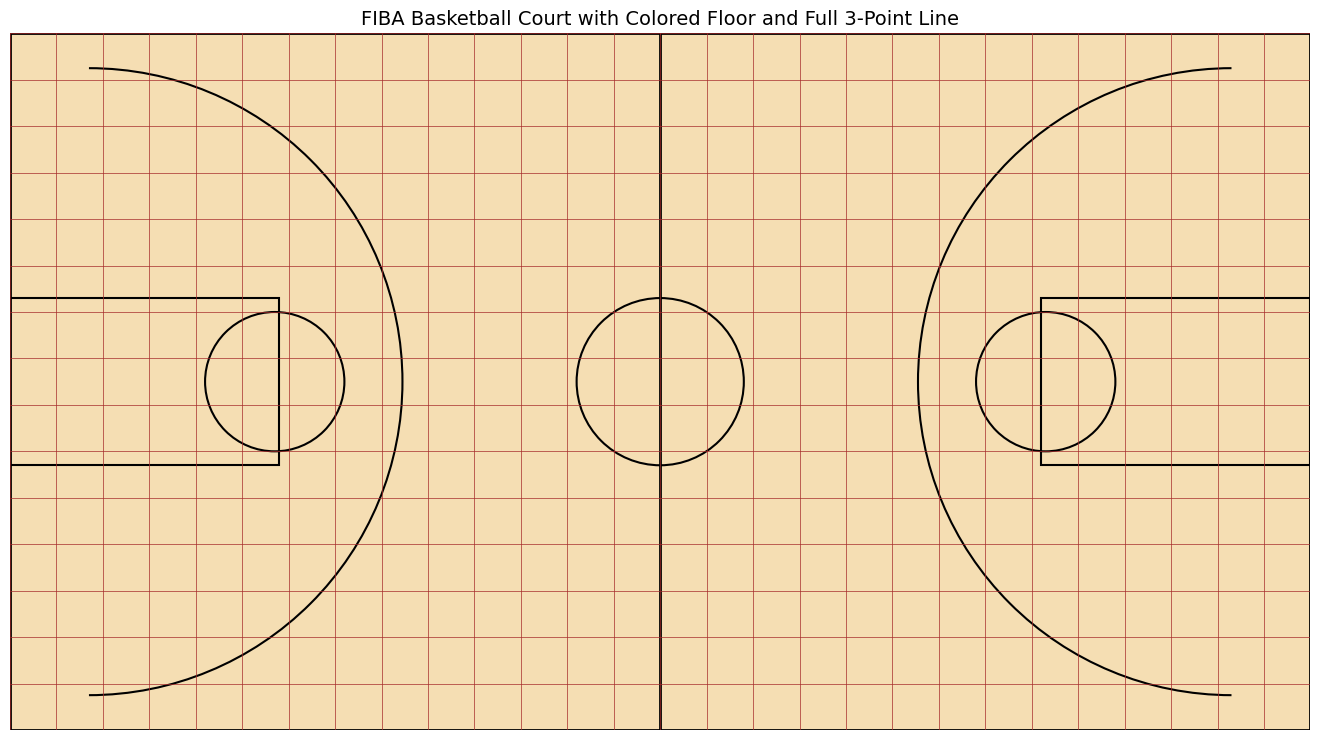

In [6]:

# FIBA court dimensions
court_length = 28  # meters
court_width = 15   # meters
 
# Basket positions
basket_x_left = 1.7
basket_x_right = court_length - 1.7
basket_y = court_width / 2
 
# 3-point radius
three_point_radius = 6.75
 
# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 7.5))
 
# Outer boundary with court color fill
court_color = '#f5deb3'  
ax.add_patch(patches.Rectangle((0, 0), court_length, court_width,
                               linewidth=2, edgecolor='black', facecolor=court_color))
 
# Center circle
ax.add_patch(patches.Circle((court_length / 2, court_width / 2), radius=1.8,
                            linewidth=1.5, edgecolor='black', facecolor='none'))
 
# Paint areas
key_width = 3.6
key_height = 5.8
ax.add_patch(patches.Rectangle((0, (court_width - key_width) / 2), key_height, key_width,
                               linewidth=1.5, edgecolor='black', facecolor='none'))
ax.add_patch(patches.Rectangle((court_length - key_height, (court_width - key_width) / 2),
                               key_height, key_width, linewidth=1.5, edgecolor='black', facecolor='none'))
 
# 3-point arcs
ax.add_patch(patches.Arc((basket_x_left, basket_y), 2 * three_point_radius, 2 * three_point_radius,
                         theta1=-90, theta2=90, edgecolor='black', linewidth=1.5))
ax.add_patch(patches.Arc((basket_x_right, basket_y), 2 * three_point_radius, 2 * three_point_radius,
                         theta1=90, theta2=270, edgecolor='black', linewidth=1.5))
 
# Vertical lines to complete 3-point arc
y_top = basket_y + three_point_radius
y_bottom = basket_y - three_point_radius
ax.plot([basket_x_left - three_point_radius]*2, [0, y_bottom], color='black', linewidth=1.5)
ax.plot([basket_x_left - three_point_radius]*2, [court_width, y_top], color='black', linewidth=1.5)
ax.plot([basket_x_right + three_point_radius]*2, [0, y_bottom], color='black', linewidth=1.5)
ax.plot([basket_x_right + three_point_radius]*2, [court_width, y_top], color='black', linewidth=1.5)
 
# Free-throw circles
free_throw_radius = 1.5
free_throw_distance = 4
ax.add_patch(patches.Circle((basket_x_left + free_throw_distance, basket_y), free_throw_radius,
                            linewidth=1.5, edgecolor='black', facecolor='none'))
ax.add_patch(patches.Circle((basket_x_right - free_throw_distance, basket_y), free_throw_radius,
                            linewidth=1.5, edgecolor='black', facecolor='none'))
 
# Mid-court line
ax.plot([court_length / 2]*2, [0, court_width], color='black', linewidth=2)
 
# Grid lines
for x in range(int(court_length) + 1):
    ax.axvline(x, color='brown', linewidth=0.5)
for y in range(int(court_width) + 1):
    ax.axhline(y, color='brown', linewidth=0.5)
 
# Final settings
ax.set_xlim(0, court_length)
ax.set_ylim(0, court_width)
ax.set_aspect('equal')
ax.axis('off')
plt.title("FIBA Basketball Court with Colored Floor and Full 3-Point Line", fontsize=14)
plt.tight_layout()
plt.show()

### Court Dimensions and Coordinate System

For this analysis, we consider a **half-court layout** based on official **FIBA basketball court dimensions**. A full FIBA court measures 28 meters in length and 15 meters in width; therefore, the half-court used here spans:

- **Length (Y-axis)**: 0 to 14 meters  
- **Width (X-axis)**: 0 to 15 meters

To perform structured spatial analysis, the court is discretized into a grid of **1×1 meter squares**. Each point on the grid corresponds to a unique position on the


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_shot_probability(prob_matrix, title="Shot Success Probability Heatmap"):
    plt.figure(figsize=(10, 6))
    sns.heatmap(prob_matrix, cmap='coolwarm', cbar_kws={'label': 'Probability'})
    plt.title(title)
    plt.xlabel("Court Width (m)")
    plt.ylabel("Court Length (m)")
    plt.gca().invert_yaxis()
    plt.show()


In [10]:


def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()


    # Create the basketball hoop
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

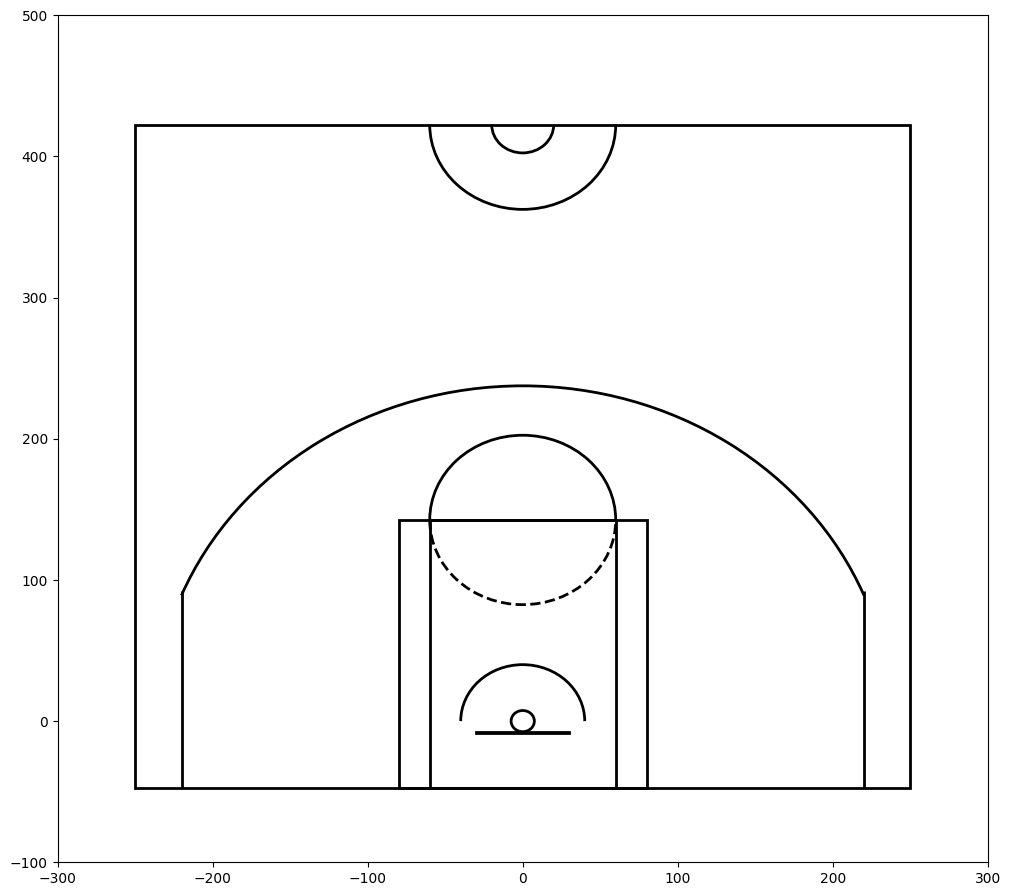

In [8]:
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

## 3. Visualizing Shot Distribution on a Custom NBA Court
 In this section, we present a method to visualize NBA player shot locations using real game data and a custom-drawn basketball court layout. The visualization offers insight into spatial shooting patterns and scoring tendencies by mapping every shot attempt to its precise court location.

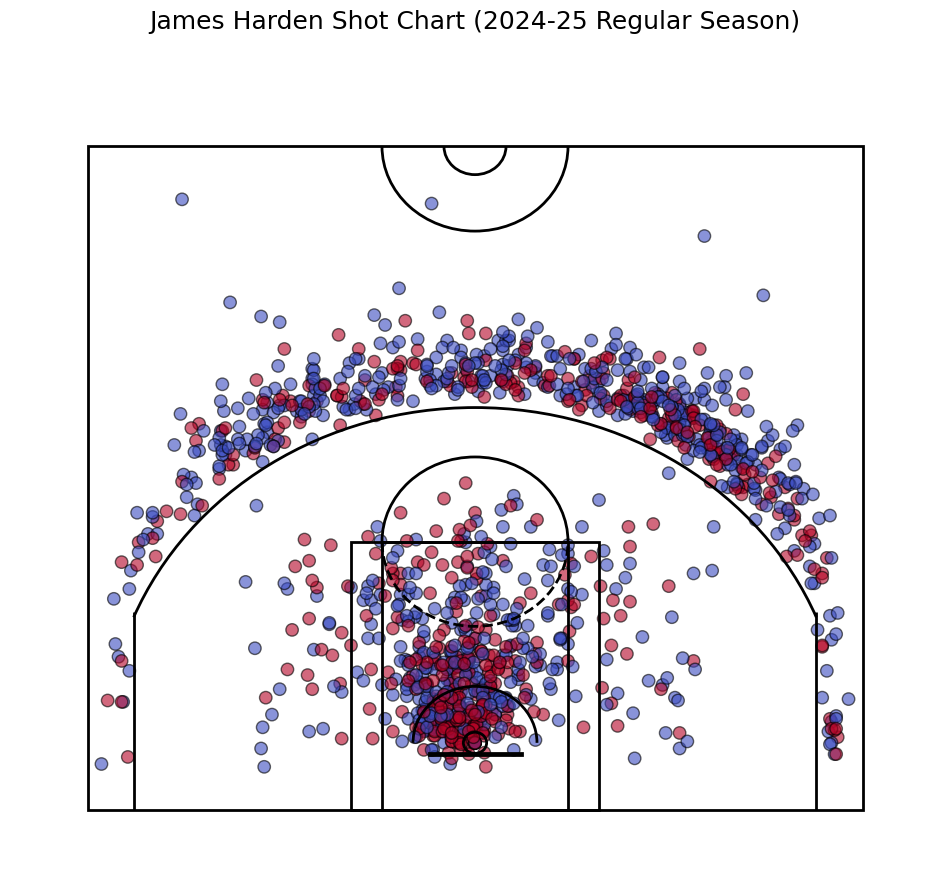

In [10]:


# --- draw_court function as you wrote ---
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()

    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0, linewidth=lw, color=color)

    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        outer = Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)
        court_elements.append(outer)

    for element in court_elements:
        ax.add_patch(element)

    return ax

# --- NBA Stats API Request ---
headers = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)',
    'Accept': 'application/json, text/plain, */*',
    'Referer': 'https://www.nba.com/',
    'Origin': 'https://www.nba.com',
    'Connection': 'keep-alive',
}

url = 'https://stats.nba.com/stats/shotchartdetail'

params = {
    'SeasonType': 'Regular Season',
    'Season': '2024-25',
    'TeamID': '0',
    'PlayerID': '201935',  # James Harden
    'GameID': '',
    'Outcome': '',
    'Location': '',
    'Month': '0',
    'SeasonSegment': '',
    'DateFrom': '',
    'DateTo': '',
    'OpponentTeamID': '0',
    'VsConference': '',
    'VsDivision': '',
    'Position': '',
    'RookieYear': '',
    'GameSegment': '',
    'Period': '0',
    'LastNGames': '0',
    'ContextMeasure': 'FGA',
    'LeagueID': '00',
    'ContextFilter': '',
    'PlayerPosition': '',
    'ZoneMode': 'Basic',
    'ShowShots': '1'
}

response = requests.get(url, headers=headers, params=params)
data = response.json()

headers = data['resultSets'][0]['headers']
shots = data['resultSets'][0]['rowSet']
shot_df = pd.DataFrame(shots, columns=headers)

# --- Plot Shot Chart ---
plt.figure(figsize=(12, 11))
plt.scatter(
    shot_df['LOC_X'], shot_df['LOC_Y'],
    c=shot_df['SHOT_MADE_FLAG'], cmap='coolwarm', alpha=0.6, s=80, edgecolors='k'
)
draw_court(outer_lines=True)
plt.xlim(-300, 300)
plt.ylim(-100, 500)
plt.title("James Harden Shot Chart (2024-25 Regular Season)", fontsize=18)
plt.xlabel('')
plt.ylabel('')
plt.axis('off')
plt.show()


###  Breakdown of API Response and DataFrame Creation (LaTeX Enhanced)

We analyze the code that retrieves NBA shot data and loads it into a DataFrame:

```python
response = requests.get(url, headers=headers, params=params)
data = response.json()

headers = data['resultSets'][0]['headers']
shots = data['resultSets'][0]['rowSet']
shot_df = pd.DataFrame(shots, columns=headers)
```

$$ texttt{response = \text{requests.get}(url, headers=headers, params=params)} $$
Sends an HTTP GET request to the NBA Stats API using URL, headers, and params.$

$$ \texttt{data = response.json()} $$
Parses the HTTP response into a Python dictionary from JSON.

$$ \texttt{data['resultSets'][0]} $$
Accesses the first result set — typically contains the shot data.

$$ \texttt{headers = data['resultSets'][0]['headers']} $$
Gets the column names for the shot dataset.

$$ \texttt{shots = data['resultSets'][0]['rowSet']} $$
Gets the actual rows of data (list of lists).

$$ \texttt{pd.DataFrame(shots, columns=headers)} $$


## Code Explanation: NBA Shot Chart Data Retrieval & Preparation

This cell outlines the process of retrieving NBA shot data and preparing it for visualization. Here's a breakdown of what the code does:

---

###  1. `draw_court` Function

- **Purpose**: Constructs and overlays a visual representation of a basketball court using `matplotlib.patches`.
- **How it works**:
  - Draws key court components: hoop, backboard, paint area, free throw arcs, three-point line, and center court arcs.
  - All elements are added to a matplotlib axis (`ax`), making the function reusable for any plot.

---

### 2. NBA Stats API Request

- **Purpose**: Connects to the NBA's public stats API to request shot data for a specific player (in this case, **James Harden**).
- **Key API parameters**:
  - `PlayerID`: Set to `201935` (James Harden).
  - `Season`: Specifies the `2024-25` regular season.
  - Other filters like team, date range, or shot zones are left open to fetch **all available shots**.

- **Headers**: Custom headers mimic a real browser request to avoid blocks or denials by the NBA API server.

---

### 3. Data Extraction

- The response is in **JSON** format and contains two keys:
  - `headers`: Column names for the data
  - `rowSet`: The actual shot data
- These are converted into a `pandas.DataFrame` called `shot_df`.

####  Important Columns:
- `LOC_X`, `LOC_Y`: Coordinates of each shot (in inches) relative to the basket
- `SHOT_MADE_FLAG`: 1 if the shot was made, 0 if missed

---

### 4. Shot Chart Plotting

- **Scatter Plot**:
  - Each shot is drawn using its X and Y position on the court.
  - Color-coded using `SHOT_MADE_FLAG` via `coolwarm` colormap:
    - Blue: Missed shots
    - Red: Made shots
  - `alpha=0.6` for transparency, and `s=80` for point size

- **Court Drawing**:
  - The `draw_court` function is used to overlay the NBA half-court layout under the scatter plot.

- **Final Touches**:
  - `plt.xlim(-300, 300)` and `plt.ylim(-100, 500)` zoom into half-court
  - Title, labels, and axes are customized or removed for a clean look


---

 This setup enables automated, programmatic generation of shot charts for **any NBA player** by adjusting just the `PlayerID` and `Season`.


In [5]:
curry_pic = mpimg.imread("curry.png")  

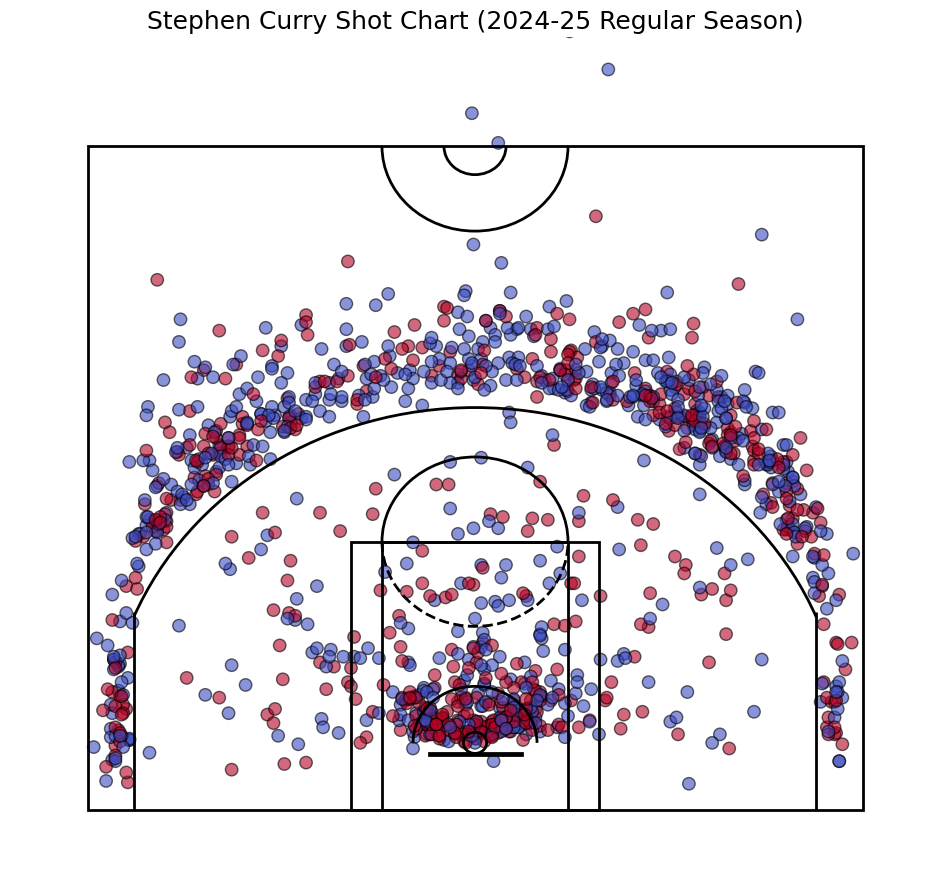

In [17]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()

    #court components
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0, linewidth=lw, color=color)

    elements = [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw,
                restricted, corner_three_a, corner_three_b, three_arc,
                center_outer_arc, center_inner_arc]

    if outer_lines:
        elements.append(Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False))

    for e in elements:
        ax.add_patch(e)

    return ax

# Get Curry's shot chart data for 2024-25 season
player_id = 201939  # Stephen Curry
shot_chart = ShotChartDetail(
    team_id=0,
    player_id=player_id,
    season_type_all_star='Regular Season',
    season_nullable='2024-25',
    context_measure_simple='FGA'
)

# Convert shot data to DataFrame
shot_df = shot_chart.get_data_frames()[0]

# Plot shot chart
plt.figure(figsize=(12, 11))
plt.scatter(
    shot_df['LOC_X'], shot_df['LOC_Y'],
    c=shot_df['SHOT_MADE_FLAG'],
    cmap='coolwarm', edgecolors='k', alpha=0.6, s=80
)
draw_court(outer_lines=True)
plt.xlim(-300, 300)
plt.ylim(-100, 500)
plt.title("Stephen Curry Shot Chart (2024-25 Regular Season)", fontsize=18)
plt.axis('off')
plt.show()


### Shots behind half court?

Some players take — and even **make** — shots from as far back as *half-court*, which is pretty incredible.  
To capture these long-range attempts accurately, we need a **full-court visualization**.  
This gives us a clearer picture of just how far out some of these shots are coming from.


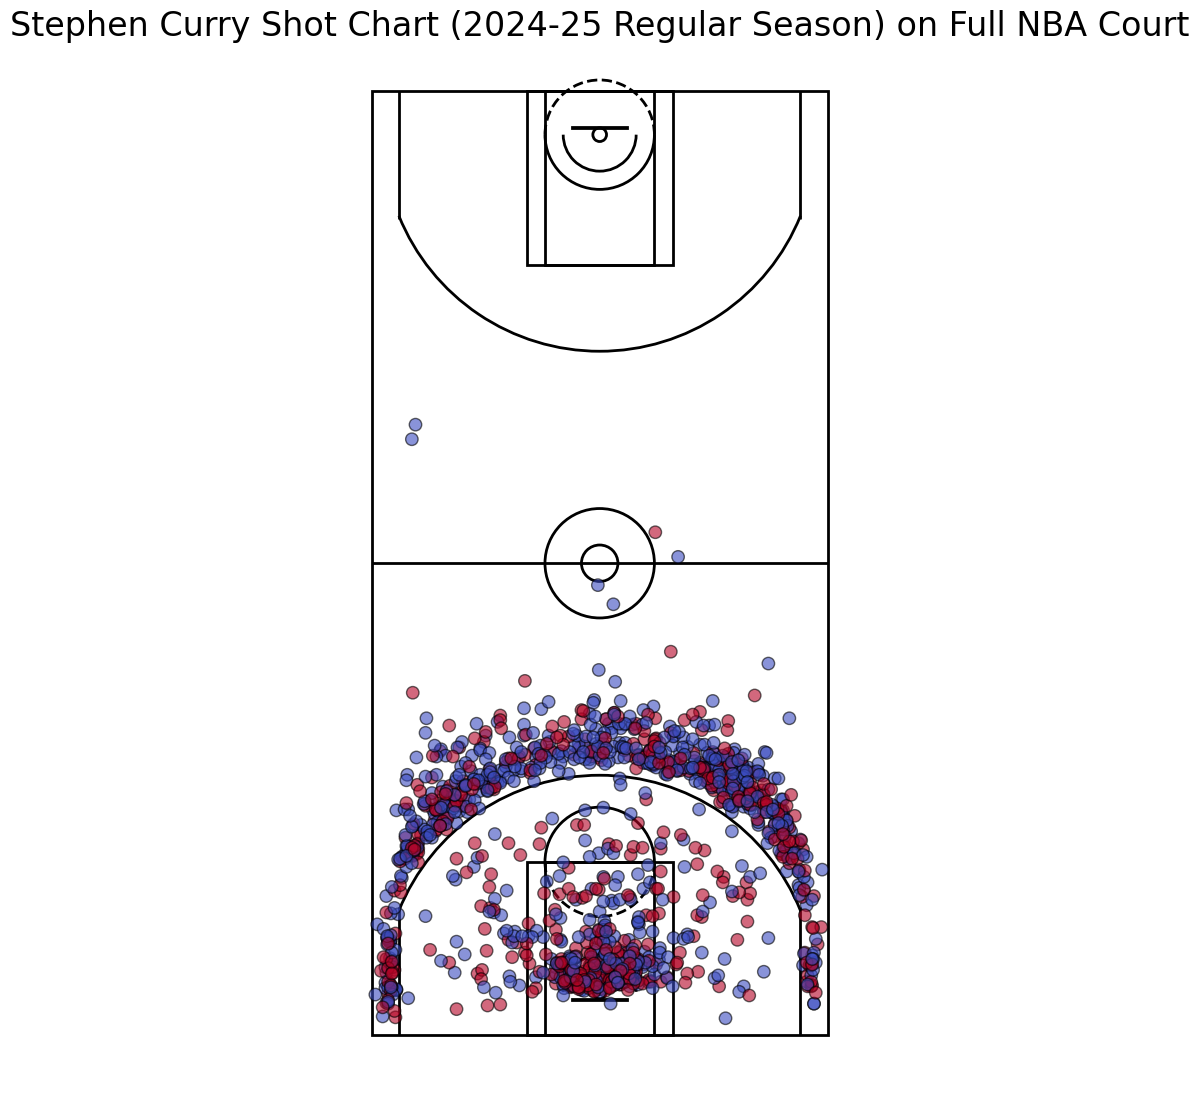

In [48]:
def draw_full_court(ax=None, color='black', lw=2, outer_lines=True):
    if ax is None:
        ax = plt.gca()

    # Hoop and backboard
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)

    # Free throw arcs
    top_ft = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color)
    bottom_ft = Arc((0, 142.5), 120, 120, theta1=180, theta2=360, linewidth=lw, color=color, linestyle='dashed')

    # Restricted area
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

    # Corner threes
    corner_left = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    corner_right = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)

    # Three-point arc
    arc3 = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)

    # Center circle
    center_outer = Circle((0, 470), 60, linewidth=lw, color=color, fill=False)
    center_inner = Circle((0, 470), 20, linewidth=lw, color=color, fill=False)

    # Center line
    center_line = Rectangle((-250, 470), 500, 0, linewidth=lw, color=color)

    # Second half (mirror court to the top)
    hoop2 = Circle((0, 940), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard2 = Rectangle((-30, 947.5), 60, 1, linewidth=lw, color=color)

    outer_box2 = Rectangle((-80, 797.5), 160, 190, linewidth=lw, color=color, fill=False)
    inner_box2 = Rectangle((-60, 797.5), 120, 190, linewidth=lw, color=color, fill=False)

    top_ft2 = Arc((0, 797.5 + 142.5), 120, 120, theta1=180, theta2=360, linewidth=lw, color=color)
    bottom_ft2 = Arc((0, 797.5 + 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, linestyle='dashed')

    restricted2 = Arc((0, 940), 80, 80, theta1=180, theta2=360, linewidth=lw, color=color)

    corner_left2 = Rectangle((-220, 847.5), 0, 140, linewidth=lw, color=color)
    corner_right2 = Rectangle((220, 847.5), 0, 140, linewidth=lw, color=color)

    arc3_2 = Arc((0, 940), 475, 475, theta1=202, theta2=338, linewidth=lw, color=color)

    outer_boundary = Rectangle((-250, -47.5), 500, 1035, linewidth=lw, color=color, fill=False)

    court_elements = [
        hoop, backboard, outer_box, inner_box, top_ft, bottom_ft, restricted,
        corner_left, corner_right, arc3,
        hoop2, backboard2, outer_box2, inner_box2, top_ft2, bottom_ft2, restricted2,
        corner_left2, corner_right2, arc3_2,
        center_outer, center_inner, center_line,
        outer_boundary
    ]

    for element in court_elements:
        ax.add_patch(element)

    return ax


# Get Curry's shot chart data for 2024-25 season
player_id = 201939  # Stephen Curry
shot_chart = ShotChartDetail(
    team_id=0,
    player_id=player_id,
    season_type_all_star='Regular Season',
    season_nullable='2024-25',
    context_measure_simple='FGA'
)

# Convert shot data to DataFrame
shot_df = shot_chart.get_data_frames()[0]

# Plot the full court with shot chart overlay
fig, ax = plt.subplots(figsize=(24, 13.5))  

draw_full_court(ax=ax)

scatter = ax.scatter(
    shot_df['LOC_X'], shot_df['LOC_Y'],
    c=shot_df['SHOT_MADE_FLAG'],
    cmap='coolwarm', edgecolors='k', alpha=0.6, s=80
)

ax.set_xlim(-300, 300)
ax.set_ylim(-100, 1040)
ax.axis('off')
ax.set_aspect('equal')
ax.set_title("Stephen Curry Shot Chart (2024-25 Regular Season) on Full NBA Court", fontsize=24)  

plt.show()

##  Stephen Curry Shot Chart: 2024–25 Regular Season

This cell generates a shot chart for **Stephen Curry** using NBA API data and a custom court-drawing function.

---

###  What the Code Does:

1. **`draw_court()`**:  
   - Defines all visual components of a standard NBA court using `matplotlib.patches`.  
   - Optionally includes outer boundary lines.

2. **NBA API Request**:  
   - Uses the `ShotChartDetail` class from the `nba_api` to pull Curry's shot data from the 2024–25 regular season.

3. **Data Handling**:  
   - Converts the raw shot data into a `pandas` DataFrame for easy plotting.
   - Each shot includes coordinates (`LOC_X`, `LOC_Y`) and whether it was made or missed (`SHOT_MADE_FLAG`).

4. **Visualization**:  
   - A scatter plot maps made/missed shots with color differentiation via the `coolwarm` colormap.
   - The court is overlaid for visual context.
   - Final touches remove axes and add a descriptive title.

---

This visualization reveals Curry’s shot distribution and accuracy across the court—essential for analytics and scouting.


<Figure size 1200x1100 with 0 Axes>

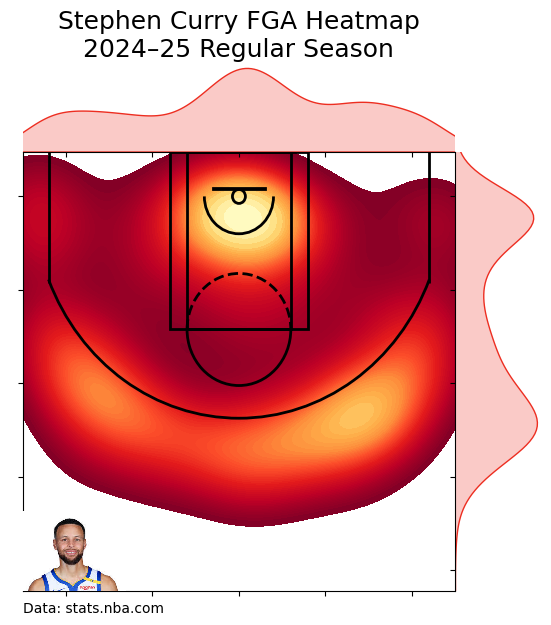

In [6]:
player_id = 201939  # Stephen Curry

shot_chart = ShotChartDetail(
    team_id=0,
    player_id=player_id,
    season_type_all_star='Regular Season',
    season_nullable='2024-25',
    context_measure_simple='FGA'
)

shot_df = shot_chart.get_data_frames()[0]

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()

    elements = [
        Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False),  # hoop
        Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color),  # backboard
        Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False),  # outer box
        Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False),  # inner box
        Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color),  # top FT
        Arc((0, 142.5), 120, 120, theta1=180, theta2=360, linewidth=lw, color=color, linestyle='dashed'),  # bottom FT
        Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color),  # restricted
        Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color),  # left corner 3
        Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color),  # right corner 3
        Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)  # 3pt arc
    ]

    if outer_lines:
        elements.append(Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False))

    for element in elements:
        ax.add_patch(element)

    return ax

# ------------------------
# Create KDE Heatmap Plot
# ------------------------
plt.figure(figsize=(12, 11))
cmap = plt.cm.YlOrRd_r

# Create KDE jointplot
joint_plot = sns.jointplot(
    x=shot_df.LOC_X,
    y=shot_df.LOC_Y,
    kind='kde',
    space=0,
    color=cmap(0.3),
    cmap=cmap,
    fill=True,
    thresh=0.05,
    levels=50
)

# Set up main axes
ax = joint_plot.ax_joint
draw_court(ax)

# Adjust view to half-court
ax.set_xlim(-250, 250)
ax.set_ylim(422.5, -47.5)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom=False, labelleft=False)

# Title & source
ax.set_title("Stephen Curry FGA Heatmap\n2024–25 Regular Season", fontsize=18, y=1.2)
ax.text(-250, 445, 'Data: stats.nba.com', fontsize=10)

img = OffsetImage(curry_pic, zoom=0.3)
ab = AnnotationBbox(img, (-195, 380), frameon=False)
ax.add_artist(ab)

plt.show()

## Stephen Curry Shot Heatmap – 2024–25 Regular Season

In this cell, we create a heatmap to visualize where Stephen Curry is taking most of his shots during the 2024–25 NBA regular season.

---

###  1. Fetching Shot Data

We use the `nba_api` package to pull real shot data for Curry. We specify that we want only regular season data for the 2024–25 season.

---

###  2. Creating the Heatmap

We use **Seaborn's KDE (kernel density estimate)** plot, which calculates where Curry shoots the most and shows that intensity using color. The deeper the red, the more frequently he shoots from that area.

We also use a reversed yellow-to-red color map (`YlOrRd_r`) that highlights hot zones.

---

###  3. Styling and Presentation

We set axis limits to match a half basketball court, remove clutter like tick labels, and add a custom title and data source.

The result is a clean and insightful visualization of Curry’s shooting tendencies.


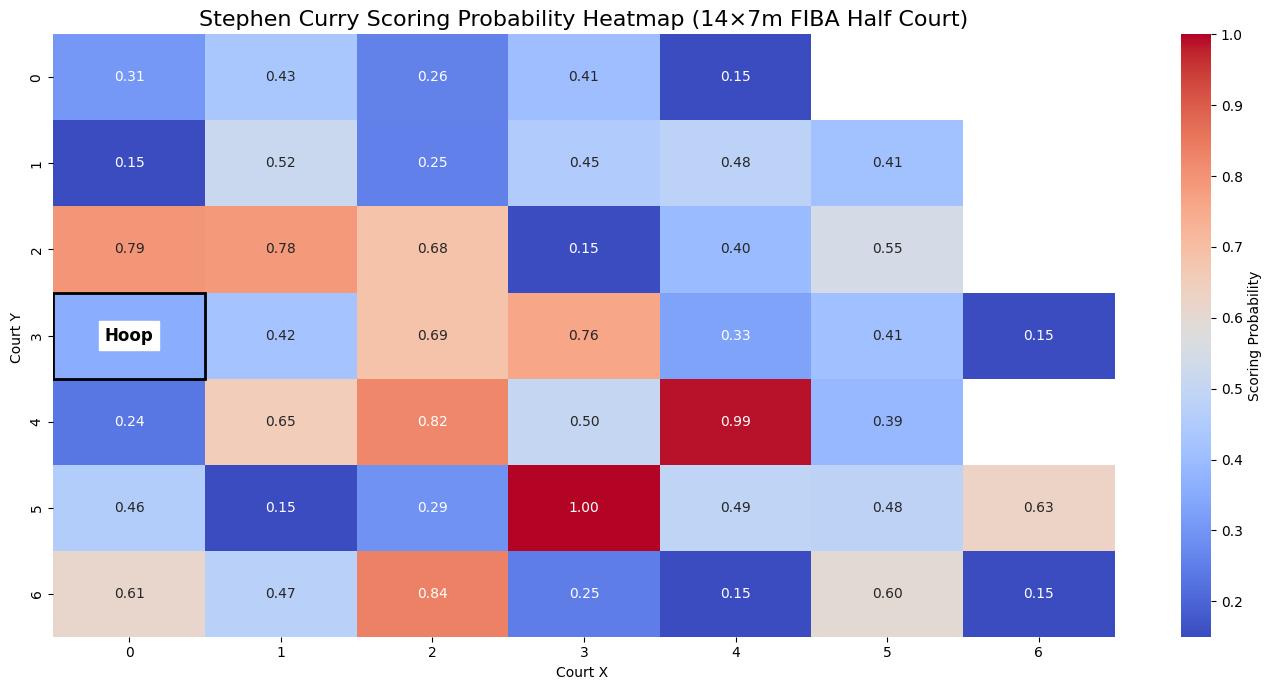

In [8]:
nba_to_m = lambda inches: inches * 0.0254

# === Normalize shot coordinates ===
# Shift hoop to (0, 3.5) --> left-middle of the 14×7 grid
shot_df['x_m'] = nba_to_m(shot_df.LOC_X)         
shot_df['y_m'] = 7 - nba_to_m(shot_df.LOC_Y)      

# === Filter to 14×7 meters ===
shot_df = shot_df[
    (shot_df['x_m'] >= 0) & (shot_df['x_m'] < 14) &
    (shot_df['y_m'] >= 0) & (shot_df['y_m'] < 7)
]

# === Bin into 1×1 meter grid ===
shot_df['x_bin'] = shot_df['x_m'].astype(int)
shot_df['y_bin'] = shot_df['y_m'].astype(int)

# === Aggregate shots per square ===
heatmap_df = shot_df.groupby(['x_bin', 'y_bin']).agg(
    FGA=('SHOT_MADE_FLAG', 'count'),
    FGM=('SHOT_MADE_FLAG', 'sum')
).reset_index()

# === Compute FG% and scoring probability ===
heatmap_df['FG%'] = heatmap_df['FGM'] / heatmap_df['FGA']

# Hoop at (0, 3.5) → center of square (0, 3)
heatmap_df['dist'] = np.sqrt((heatmap_df['x_bin'] + 0.5 - 0)**2 + (heatmap_df['y_bin'] + 0.5 - 3.5)**2)
heatmap_df['ScoreProb'] = heatmap_df['FG%'] * np.exp(-0.02 * heatmap_df['dist'])

# === Normalize scoring probability ===
min_prob = heatmap_df['ScoreProb'].min()
max_prob = heatmap_df['ScoreProb'].max()
heatmap_df['ScoreProbNorm'] = (heatmap_df['ScoreProb'] - min_prob) / (max_prob - min_prob)
heatmap_df['ScoreProbNorm'] = heatmap_df['ScoreProbNorm'].clip(lower=0.15)

# === Pivot into matrix for heatmap ===
score_matrix = heatmap_df.pivot(index='y_bin', columns='x_bin', values='ScoreProbNorm')
score_matrix = score_matrix.sort_index(ascending=False)  

# === Plot heatmap ===
plt.figure(figsize=(14, 7))
sns.heatmap(score_matrix, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Scoring Probability'})

# === Mark hoop square at (x=0, y=3) ===
ax = plt.gca()
hoop_rect = patches.Rectangle((0, 3), 1, 1, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(hoop_rect)
ax.text(0.5, 3.5, 'Hoop', color='black', ha='center', va='center', fontsize=12, weight='bold', backgroundcolor='white')


plt.title("Stephen Curry Scoring Probability Heatmap (14×7m FIBA Half Court)", fontsize=16)
plt.xlabel("Court X ")
plt.ylabel("Court Y ")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show() 

###  Stephen Curry Scoring Probability Heatmap (14×7m FIBA Half Court)

This cell generates a heatmap visualizing Stephen Curry's scoring probability across a FIBA-style half court using real shot location data.

---

###  Court Setup
- **Court Dimensions:** 14 meters wide × 7 meters deep — half of a standard FIBA court.
- **Grid Resolution:** 1×1 meter squares → 14 columns × 7 rows.
- **Hoop Location:** Left-middle at the center of bin `(x=0, y=3.5)`.

---

### Processing Steps

1. **Coordinate Conversion & Normalization**  
   - Converts NBA coordinates from inches to meters.
   - Flips the Y-axis so `y=0` starts at the baseline (FIBA orientation).
   - X=0 remains at the left sideline. The hoop is placed at (0, 3.5).

2. **Spatial Binning**  
   - Filters shots within the 14×7 meter FIBA half court.
   - Each shot is placed into a 1×1 meter bin using `floor` (via `.astype(int)`).

3. **Shot Aggregation**  
   - For each bin:
     - `FGA` = total shots attempted.
     - `FGM` = total shots made.
     - `FG%` = field goal percentage = `FGM / FGA`.

4. **Scoring Probability Estimation**  
   - Calculates distance `d` from bin center to hoop `(0.5, y+0.5 → 0, 3.5)`.
   - Applies exponential decay model:  
     $$
     \text{ScoreProb} = \text{FG\%} \times e^{-0.02 \cdot d}
     $$  
   - This models how scoring gets harder as distance increases, even for high FG%.

5. **Normalization**  
   - ScoreProb is linearly scaled to `[0, 1]` range for heatmap coloring.
   - Values below 0.15 are clipped to ensure weak zones still show up visually.

6. **Visualization**  
   - A `seaborn.heatmap` displays `ScoreProb` across the court.
   - The hoop square `(0, 3)` is highlighted with a black rectangle and labeled `"Hoop"`.

---

### Outcome

This heatmap shows Curry's relative scoring probability across different areas of a FIBA half court. It's useful for performance analysis, coaching strategy, and spatial efficiency insights.


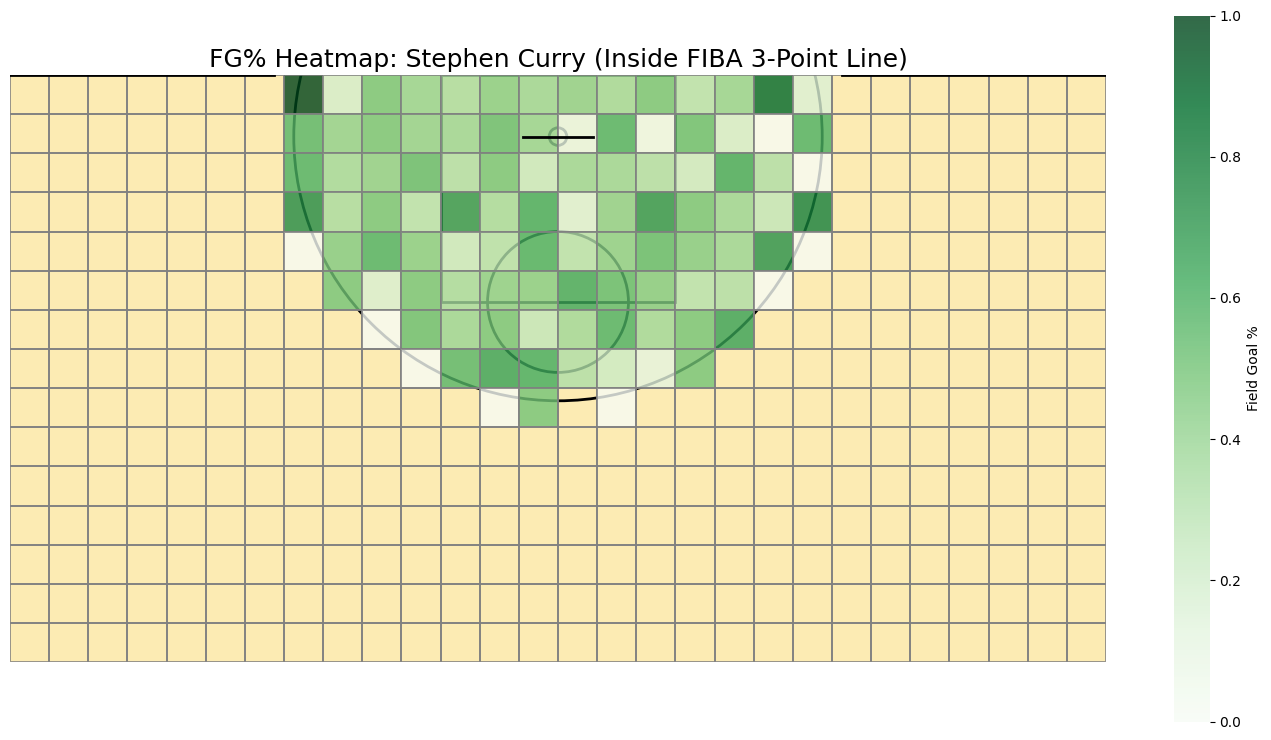

In [16]:
np.random.seed(42)
mock_shots = 2000
shot_df = pd.DataFrame({
    'LOC_X': np.random.normal(0, 250, mock_shots),  
    'LOC_Y': np.random.normal(100, 100, mock_shots), 
    'SHOT_MADE_FLAG': np.random.binomial(1, 0.45, mock_shots)
})

# Conversion constants
inch_to_meter = 0.0254

# Convert LOC_X, LOC_Y to meters and shift to FIBA court reference (origin under the basket)
shot_df['x_m'] = shot_df['LOC_X'] * inch_to_meter + 14
shot_df['y_m'] = shot_df['LOC_Y'] * inch_to_meter + 1.575

# Limit to 3-point range (6.75m radius from hoop at (14, 1.575))
distance_from_hoop = np.sqrt((shot_df['x_m'] - 14) ** 2 + (shot_df['y_m'] - 1.575) ** 2)
shot_df = shot_df[distance_from_hoop <= 6.75]

# Create 1x1m bins
shot_df['x_bin'] = shot_df['x_m'].clip(0, 27.99).astype(int)
shot_df['y_bin'] = shot_df['y_m'].clip(0, 14.99).astype(int)

# Group and calculate FG%
grouped = shot_df.groupby(['x_bin', 'y_bin'])
fg_df = grouped['SHOT_MADE_FLAG'].agg(['mean', 'count']).reset_index()
fg_df.columns = ['x_bin', 'y_bin', 'fg_pct', 'shot_count']

# Create pivot table for heatmap
x_range = np.arange(0, 28)
y_range = np.arange(0, 15)
heatmap_data = fg_df.pivot(index='y_bin', columns='x_bin', values='fg_pct').reindex(index=y_range, columns=x_range)

# Function to draw FIBA court
def draw_fiba_court(ax=None, color='black', lw=2):
    if ax is None:
        ax = plt.gca()
    ax.add_patch(patches.Rectangle((0, 0), 28, 15, linewidth=0, facecolor='#fcebb3'))  # court background
    ax.add_patch(patches.Rectangle((11, 0), 6, 5.8, linewidth=lw, edgecolor=color, facecolor='none'))  # paint
    ax.plot([13.1, 14.9], [1.575, 1.575], color=color, linewidth=lw)  # backboard
    rim = plt.Circle((14, 1.575), 0.225, linewidth=lw, color=color, fill=False)  # rim
    ax.add_patch(rim)
    ft = plt.Circle((14, 5.8), 1.8, linewidth=lw, color=color, fill=False)  # free throw circle
    ax.add_patch(ft)
    ax.plot([0, 6.75], [0, 0], color=color, linewidth=lw)
    ax.plot([21.25, 28], [0, 0], color=color, linewidth=lw)
    arc = plt.Circle((14, 1.575), 6.75, color=color, fill=False, linewidth=lw)
    ax.add_patch(arc)
    ax.set_xlim(0, 28)
    ax.set_ylim(0, 15)
    ax.set_aspect('equal')
    ax.axis('off')

# Plot heatmap
plt.figure(figsize=(14, 7.5))
ax = plt.gca()
draw_fiba_court(ax)

sns.heatmap(
    heatmap_data,
    cmap="Greens",
    linewidths=0.3,
    linecolor='gray',
    cbar_kws={'label': 'Field Goal %'},
    ax=ax,
    alpha=0.8,
    xticklabels=2,
    yticklabels=2
)

plt.title("FG% Heatmap: Stephen Curry (Inside FIBA 3-Point Line)", fontsize=18)
plt.tight_layout()
plt.show()

###  Where Does Stephen Curry Truly Shine? A Heatmap Within the FIBA 3-Point Line

This cell simulates and visualizes Stephen Curry’s shooting efficiency **within the 6.75-meter arc**, adjusted to FIBA court dimensions. The result? A fine-grained, spatial analysis of his **Field Goal Percentage (FG%)** across the half court.

---

####  **Methodology Overview**

1. **Synthetic Shot Simulation**
   - We generate 2,000 mock shots with locations drawn from normal distributions around expected shooting zones.
   - Shot outcomes are simulated using a binomial distribution with a base FG% of 45%.

2. **Coordinate Transformation**
   - Original coordinates (in inches) are converted to meters.
   - All shots are translated to a FIBA court layout, with the **hoop placed at `(14, 1.575)`** — consistent with real-world court dimensions.

3. **Distance Filtering**
   - To isolate performance *inside* the FIBA 3-point line, we filter shots to those **within 6.75 meters of the hoop**.

4. **Spatial Binning**
   - The court is divided into **1×1 meter bins**.
   - For each bin, we calculate:
     - **Field Goal % (FG%)**: proportion of made shots.
     - **Shot Count**: number of attempts per zone (used to assess reliability).

5. **Heatmap Construction**
   - A pivot table is created to form a 28×15 matrix (meters).
   - Each cell is color-coded based on FG%, revealing Curry’s shooting tendencies across space.

6. **FIBA Court Overlay**
   - A custom function draws standard FIBA court elements: paint area, backboard, rim, free-throw circle, and the 3-point arc.
   - This ensures spatial context is preserved, allowing us to interpret performance zones accurately.

---

####  **Why It Matters**

This visualization isn't just about numbers — it's about **translating shooting data into spatial intuition**. By examining this heatmap:

- Coaches can identify high-efficiency zones for play design.
- Analysts can quantify shot quality in different court areas.
- Fans and researchers gain insight into how **court geometry influences player performance**.

So, the next time someone says Curry is deadly from deep — show them this and ask: *Have you ever thought what could have been if he was plating on a FIBA court?*


## 4.  Simulated Shot Frequency Heatmap - Formula
#### What if we could model basketball shot frequency without needing tracking data?  
#### This simulation does just that — by assuming players are more likely to shoot:
#### -  Close to the rim
#### -  Around the 3-point arc
#### We’ll simulate a full half-court heatmap using a mathematical formula based on distance.

##  Simulated Shot Frequency Heatmaps: Stephen Curry vs LeBron James vs Kevin Durant 

These visualizations show estimated shot frequency zones for **LeBron James** and **Kevin Durant** on a FIBA half-court. While not based on real data, they reflect general tendencies in each player’s offensive game using simulated Gaussian-based zones.

### Player Tendencies

| Player         | Key Shot Areas                         |
|----------------|----------------------------------------|
| LeBron James   | Paint, left elbow, corners             |
| Kevin Durant   | Elbows, wings, top of arc   
| Stephen Curry   | Deep threes, wings, top of arc, corners, rim 

Each heatmap is a visual approximation of where these players are most active or effective based on their known play styles.


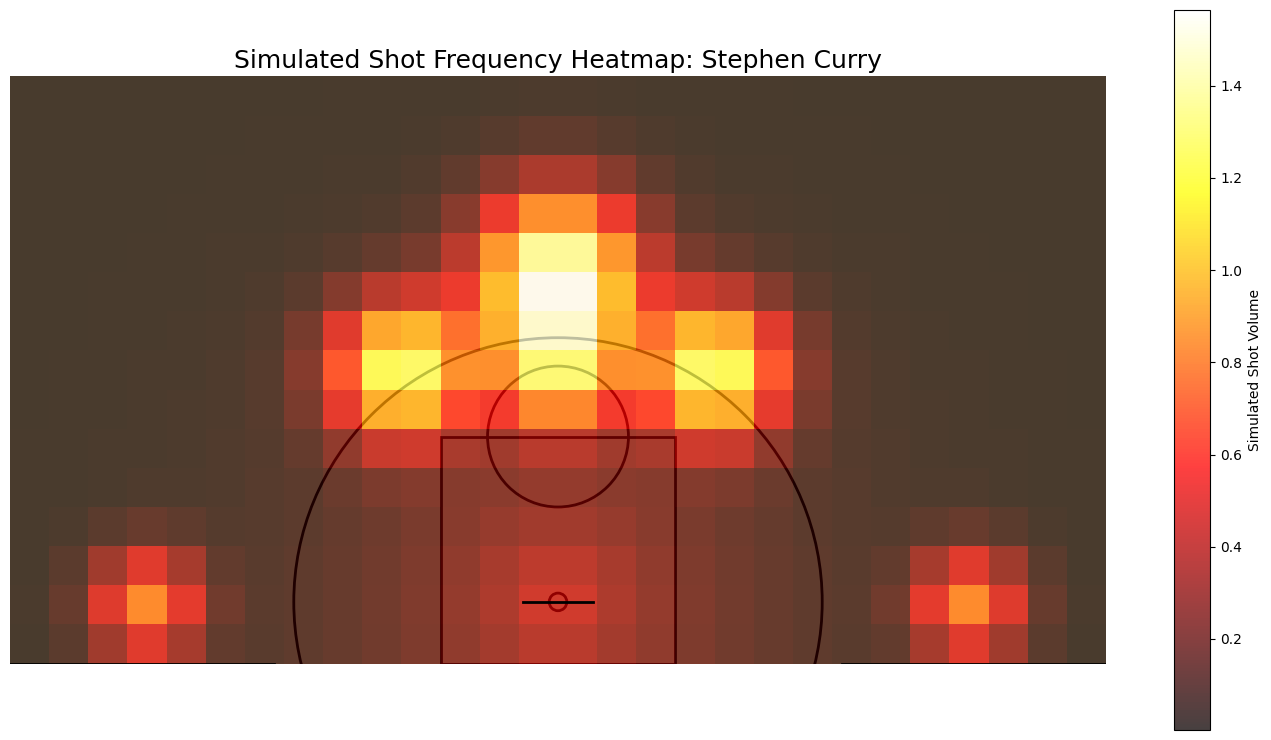

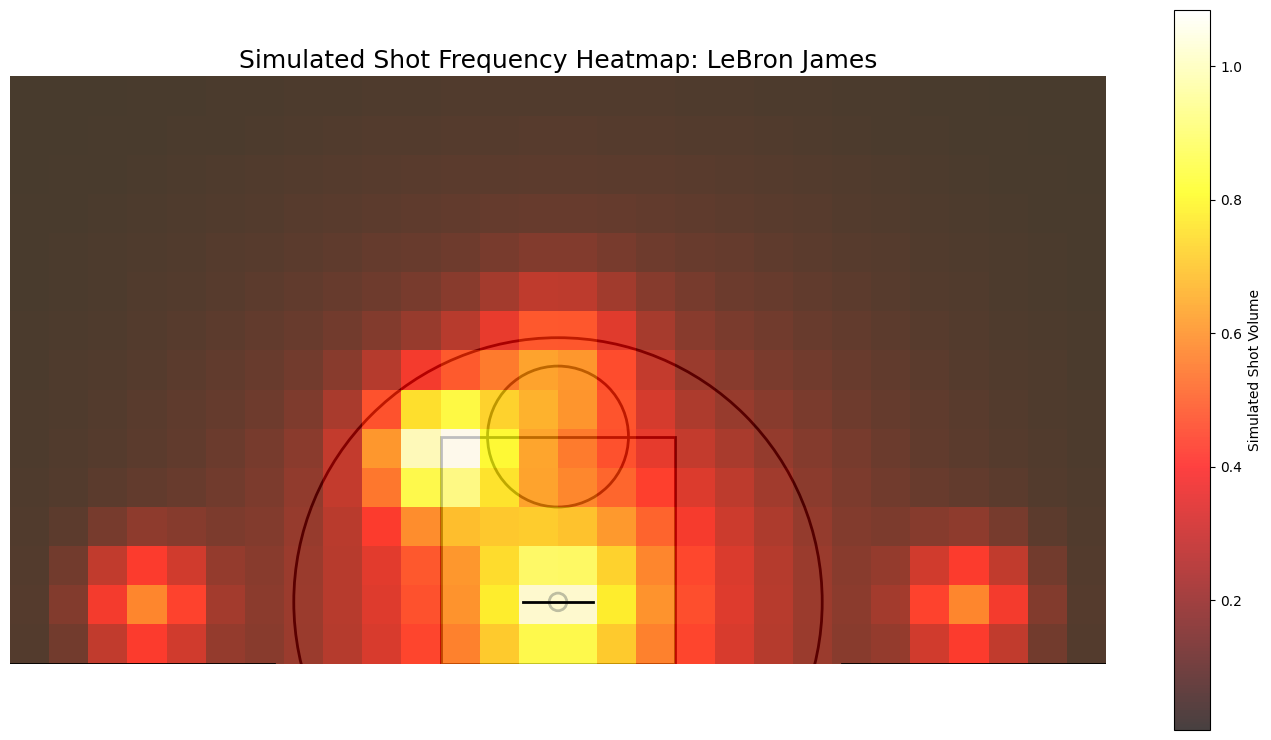

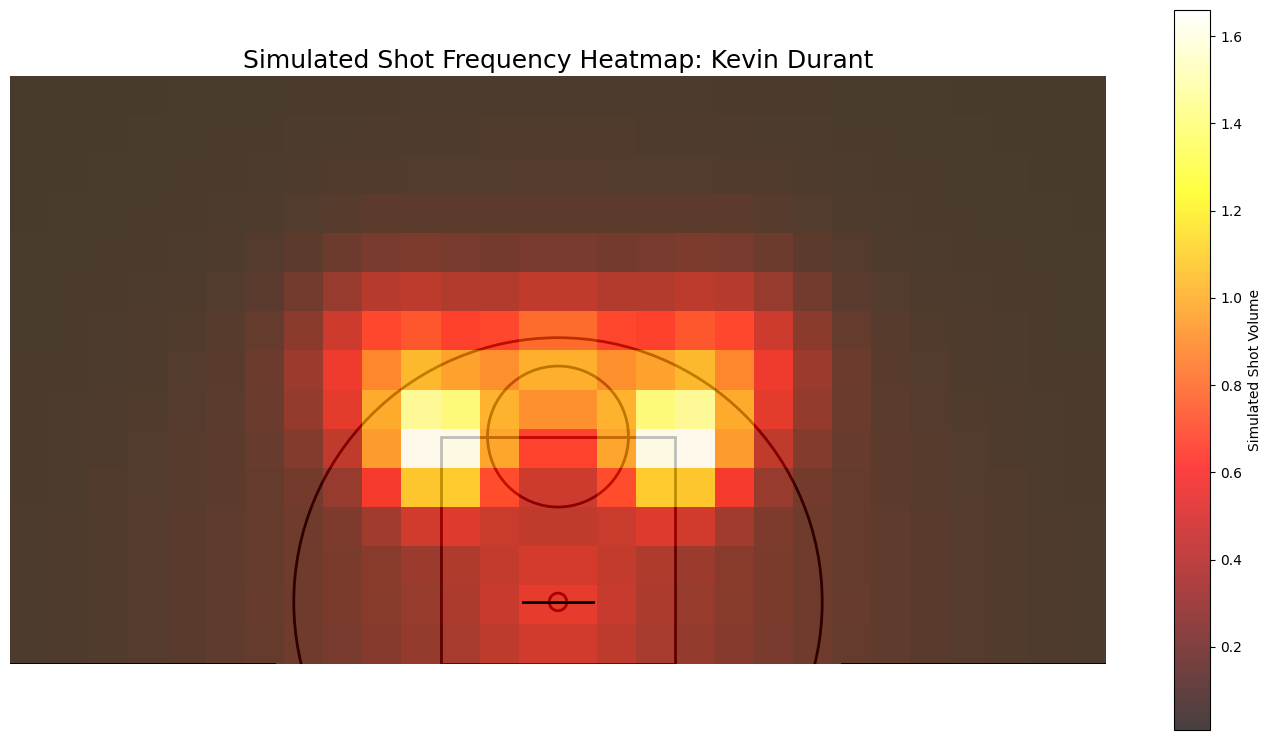

In [11]:


def simulate_heatmap(player='LeBron'):
    width, height = 28, 15
    x_edges = np.arange(0, width + 1, 1)
    y_edges = np.arange(0, height + 1, 1)
    heatmap = np.zeros((len(y_edges)-1, len(x_edges)-1))
    hoop_x, hoop_y = 14, 1.575

    for i in range(len(y_edges)-1):
        for j in range(len(x_edges)-1):
            x = j + 0.5
            y = i + 0.5
            dist = np.sqrt((x - hoop_x)**2 + (y - hoop_y)**2)

            if player == 'LeBron':
                paint = np.exp(-dist / 3.5)
                left_elbow = np.exp(-((x - 11)**2 + (y - 5.5)**2) / 3)
                left_corner = np.exp(-((x - 3.5)**2 + (y - 1.5)**2) / 2.5)
                right_corner = np.exp(-((x - 24.5)**2 + (y - 1.5)**2) / 2.5)
                top_arc = np.exp(-((x - 14)**2 + (y - 7.5)**2) / 4)
                heatmap[i, j] = (
                    1.2 * paint +
                    0.8 * left_elbow +
                    0.5 * left_corner +
                    0.5 * right_corner +
                    0.4 * top_arc
                )

            elif player == 'KD':
                paint = 0.6 * np.exp(-dist / 4.5)
                left_elbow = np.exp(-((x - 11)**2 + (y - 5.5)**2) / 2.2)
                right_elbow = np.exp(-((x - 17)**2 + (y - 5.5)**2) / 2.2)
                top_arc = np.exp(-((x - 14)**2 + (y - 7.5)**2) / 4)
                left_wing = np.exp(-((x - 10)**2 + (y - 7.5)**2) / 5)
                right_wing = np.exp(-((x - 18)**2 + (y - 7.5)**2) / 5)
                heatmap[i, j] = (
                    paint +
                    1.3 * left_elbow +
                    1.3 * right_elbow +
                    0.8 * top_arc +
                    0.7 * left_wing +
                    0.7 * right_wing
                )

            elif player == 'Curry':
                long_three = np.exp(-((x - 14)**2 + (y - 10)**2) / 4)
                left_wing = np.exp(-((x - 10)**2 + (y - 7.5)**2) / 3)
                right_wing = np.exp(-((x - 18)**2 + (y - 7.5)**2) / 3)
                top_arc = np.exp(-((x - 14)**2 + (y - 7.5)**2) / 2.5)
                corners = (
                    np.exp(-((x - 3.5)**2 + (y - 1.5)**2) / 1.8) +
                    np.exp(-((x - 24.5)**2 + (y - 1.5)**2) / 1.8)
                )
                layup = np.exp(-dist / 3.5)

                heatmap[i, j] = (
                    1.5 * long_three +
                    1.3 * left_wing +
                    1.3 * right_wing +
                    1.0 * top_arc +
                    0.8 * corners +
                    0.5 * layup
                )

    return heatmap, x_edges, y_edges

def draw_fiba_court(ax, width=28, height=15, color='black', lw=2):
    ax.add_patch(patches.Rectangle((0, 0), width, height, facecolor='#fcebb3'))
    ax.add_patch(patches.Rectangle((11, 0), 6, 5.8, linewidth=lw, edgecolor=color, facecolor='none'))
    ax.plot([13.1, 14.9], [1.575, 1.575], color=color, linewidth=lw)
    ax.add_patch(plt.Circle((14, 1.575), 0.225, color=color, fill=False, linewidth=lw))
    ax.add_patch(plt.Circle((14, 5.8), 1.8, color=color, fill=False, linewidth=lw))
    ax.plot([0, 6.75], [0, 0], color=color, linewidth=lw)
    ax.plot([21.25, 28], [0, 0], color=color, linewidth=lw)
    ax.add_patch(plt.Circle((14, 1.575), 6.75, color=color, fill=False, linewidth=lw))

# --- Curry Heatmap ---
heatmap, x_edges, y_edges = simulate_heatmap(player='Curry')
fig, ax = plt.subplots(figsize=(14, 7.5))
draw_fiba_court(ax)
c = ax.pcolormesh(x_edges, y_edges, heatmap, cmap='hot', shading='auto', alpha=0.75)
ax.set_xlim(0, 28)
ax.set_ylim(0, 15)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Simulated Shot Frequency Heatmap: Stephen Curry", fontsize=18)
plt.colorbar(c, ax=ax, label="Simulated Shot Volume")
plt.tight_layout()
plt.show()

# --- LeBron Heatmap ---
heatmap, x_edges, y_edges = simulate_heatmap(player='LeBron')
fig, ax = plt.subplots(figsize=(14, 7.5))
draw_fiba_court(ax)
c = ax.pcolormesh(x_edges, y_edges, heatmap, cmap='hot', shading='auto', alpha=0.75)
ax.set_xlim(0, 28)
ax.set_ylim(0, 15)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Simulated Shot Frequency Heatmap: LeBron James", fontsize=18)
plt.colorbar(c, ax=ax, label="Simulated Shot Volume")
plt.tight_layout()
plt.show()

# --- KD Heatmap ---
heatmap, x_edges, y_edges = simulate_heatmap(player='KD')
fig, ax = plt.subplots(figsize=(14, 7.5))
draw_fiba_court(ax)
c = ax.pcolormesh(x_edges, y_edges, heatmap, cmap='hot', shading='auto', alpha=0.75)
ax.set_xlim(0, 28)
ax.set_ylim(0, 15)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Simulated Shot Frequency Heatmap: Kevin Durant", fontsize=18)
plt.colorbar(c, ax=ax, label="Simulated Shot Volume")
plt.tight_layout()
plt.show()


#  Simulated Shot Frequency Heatmaps for NBA Players on a FIBA Court

This notebook simulates and visualizes the shot frequency heatmaps of **Stephen Curry**, **LeBron James**, and **Kevin Durant** on a **FIBA basketball court** using a 28x15 meter grid.

---

##  1. `simulate_heatmap()` Function

This function returns a `heatmap` array that models a player's shot frequency based on approximate court locations.

###  Court Setup

- The FIBA court is divided into 1×1 meter squares:

$$
x \in [0, 28], \quad y \in [0, 15]
$$

- The basket is placed at:

$$
(\text{hoop}_x, \text{hoop}_y) = (14, 1.575)
$$

###  Player-Specific Models

Each player's heatmap is generated by summing weighted exponential functions centered on typical shot locations.

####  LeBron James

$$
\text{heatmap}_{i,j} = 
1.2 \cdot e^{-d/3.5} +
0.8 \cdot e^{-\frac{(x - 11)^2 + (y - 5.5)^2}{3}} +
0.5 \cdot e^{-\frac{(x - 3.5)^2 + (y - 1.5)^2}{2.5}} +
0.5 \cdot e^{-\frac{(x - 24.5)^2 + (y - 1.5)^2}{2.5}} +
0.4 \cdot e^{-\frac{(x - 14)^2 + (y - 7.5)^2}{4}}
\
$$

#### Kevin Durant

$$
\text{heatmap}_{i,j} =
0.6 \cdot e^{-d/4.5} +
1.3 \cdot \left( e^{-\frac{(x - 11)^2 + (y - 5.5)^2}{2.2}} + e^{-\frac{(x - 17)^2 + (y - 5.5)^2}{2.2}} \right) +
0.8 \cdot e^{-\frac{(x - 14)^2 + (y - 7.5)^2}{4}} +
0.7 \cdot \left( e^{-\frac{(x - 10)^2 + (y - 7.5)^2}{5}} + e^{-\frac{(x - 18)^2 + (y - 7.5)^2}{5}} \right)
$$

#### Stephen Curry

$$
\text{heatmap}_{i,j} =
1.5 \cdot e^{-\frac{(x - 14)^2 + (y - 10)^2}{4}} +
1.3 \cdot \left( e^{-\frac{(x - 10)^2 + (y - 7.5)^2}{3}} + e^{-\frac{(x - 18)^2 + (y - 7.5)^2}{3}} \right) +
1.0 \cdot e^{-\frac{(x - 14)^2 + (y - 7.5)^2}{2.5}} +
0.8 \cdot \left( e^{-\frac{(x - 3.5)^2 + (y - 1.5)^2}{1.8}} + e^{-\frac{(x - 24.5)^2 + (y - 1.5)^2}{1.8}} \right) +
0.5 \cdot e^{-d/3.5}
\
$$

Where $$( d = \sqrt{(x - 14)^2 + (y - 1.575)^2} $$ is the distance to the hoop.

---

##  2. `draw_fiba_court()` Function

This function draws a FIBA basketball court with:

- Court rectangle: \(28 times 15\) meters
- Paint area: \(6 \times 5.8\) meters
- Free throw line and circle
- Three-point line:
  - Side: 6.75 m from hoop
  - Arc radius: 6.75 m

###  Key Geometry

- Hoop: \( (14, 1.575) \)
- Paint: rectangle from \( (11, 0) \) to \( (17, 5.8) \)
- Three-point arc: circle centered at hoop with \( r = 6.75 \)

---

##  3. Heatmap Visualization

Each heatmap is visualized using:

$$
\text{matplotlib.pyplot.pcolormesh}(x_{\text{edges}}, y_{\text{edges}}, \text{heatmap})
$$

Features:

- `cmap='hot'` for heat intensity
- `alpha=0.75` for blending
- Court overlay via `draw_fiba_court()`
- Title and colorbar for context

---

##  Summary

This simulation approximates the shot tendencies of Curry, LeBron, and KD on a FIBA-sized court, offering insight into their most frequent shooting zones using mathematical modeling and heatmap visualization.
This heatmap serves as an intuitive guide for players, coaches, and analysts to assess shot efficiency across the court.

##  5. Conclusion: Data Science Meets Basketball Strategy

This project demonstrates how **mathematical modeling** and **machine learning** can deliver **actionable insights** in professional sports. By estimating shot success probabilities across different court positions, we lay a strong foundation for **strategic basketball analysis**.

###  Key Findings

- **Proximity to the basket** has a major influence on scoring probability — the closer the shot, the higher the chance of success.  
- **Shot angle** matters — shots taken from central, straight-on positions are generally more accurate.  
- **Heatmaps** provide powerful visual tools for identifying shooting efficiencies and inefficiencies across the court.

###  Applications

These insights can directly support:
- **Coaching strategies** (e.g., shot selection and play design)
- **Defensive planning** (e.g., zone prioritization)
- **Player development** (e.g., personalized training focus)

###  Future Directions

To build on this work, we could:
- Integrate **real NBA game data**
- Include **player-specific tendencies** and defensive pressure
- Apply more advanced models like **Random Forests**, **XGBoost**, or **Deep Learning**

---

By combining **geometry, probability, and analytics**, we illuminate the hidden patterns behind the game. This project exemplifies the growing synergy between **data science and sports strategy**, opening doors to smarter decisions and a deeper understanding of basketball.


Author: Dimitar Dimov
© 2025. All rights reserved.